In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [2]:
root = 'data/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
weather_train_df["timestamp"] = pd.to_datetime(weather_train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

# test_df = pd.read_csv(root + 'test.csv')
# test_df["hour"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S').dt.hour

# weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
# sample_submission = pd.read_csv(root + 'sample_submission.csv')

In [202]:
weather_test_df = pd.read_csv(root + 'weather_test.csv')
weather_test_df = reduce_mem_usage(weather_test_df)
weather_test_df.isnull().sum() / len(weather_test_df)

Mem. usage decreased to  6.08 Mb (68.1% reduction)


site_id               0.000000
timestamp             0.000000
air_temperature       0.000375
cloud_coverage        0.506588
dew_temperature       0.001179
precip_depth_1_hr     0.344781
sea_level_pressure    0.076702
wind_direction        0.044618
wind_speed            0.001659
dtype: float64

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [5]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [6]:
building_meta_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

In [35]:
weather_train_df.isnull().sum() / len(weather_train_df)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [36]:
# we can take into account air temperature only

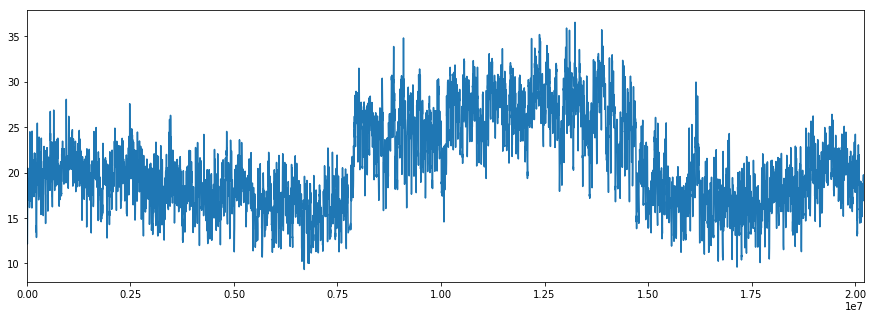

In [24]:
plt.figure(figsize = (15,5))
train_df.query('building_id==348 and meter==0')['meter_reading'].plot()
plt.show()

In [25]:
building_meta_df[building_meta_df.building_id==348]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
348,3,348,Public services,10577,1969.0,NaN


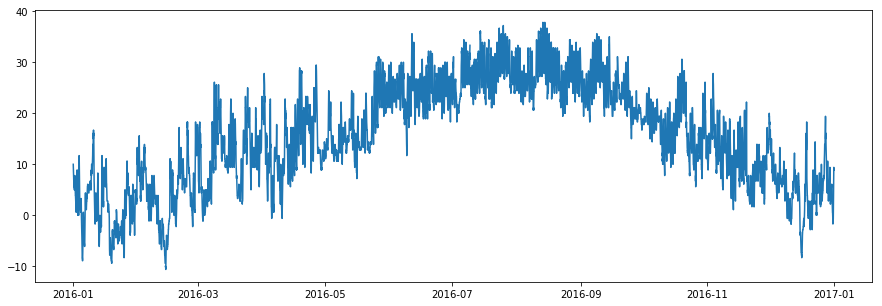

In [26]:
t = weather_train_df[weather_train_df.site_id==3][['timestamp','air_temperature']].values

ts, te = zip(*t)
plt.figure(figsize = (15,5))
plt.plot(ts, te)
plt.show()

In [45]:
# let us take data for some building
b_348 = train_df.query('building_id==348 and meter==0')
b_348.head()

,building_id,meter,timestamp,meter_reading
508,348,0,2016-01-01 00:00:00,15.17
2807,348,0,2016-01-01 01:00:00,13.32
5102,348,0,2016-01-01 02:00:00,13.28
7400,348,0,2016-01-01 03:00:00,13.03
9695,348,0,2016-01-01 04:00:00,12.14


In [40]:
building_meta_df[building_meta_df.building_id==348]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
348,3,348,Public services,10577,1969.0,NaN


In [517]:
# so, this building is in site 3
# let us merge it with weather for this site
b = b_348.drop(columns=['building_id', 'meter'])
weather_3 = weather_train_df[weather_train_df.site_id ==3 ]
b = pd.merge(b, weather_3, on='timestamp')
b = b.drop(columns=['site_id', 'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 
                    'wind_direction', 'wind_speed'])
b = b.dropna()
b['workhour'] = np.abs(b['timestamp'].dt.hour - 10.5) < 6.5
b['workday'] = b['timestamp'].dt.weekday < 6
print("rows in dataset:", len(b))
b.head()

rows in dataset: 8748


,timestamp,meter_reading,air_temperature,dew_temperature,workhour,workday
0,2016-01-01 00:00:00,15.17,10.000000,2.199219,False,True
1,2016-01-01 01:00:00,13.32,9.398438,2.800781,False,True
2,2016-01-01 02:00:00,13.28,8.898438,2.199219,False,True
3,2016-01-01 03:00:00,13.03,7.800781,1.099609,False,True
4,2016-01-01 04:00:00,12.14,7.800781,0.600098,False,True


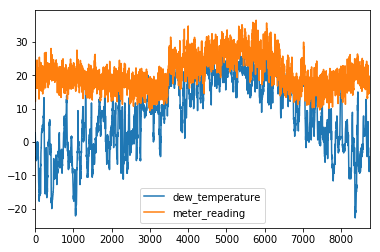

In [485]:
b[['dew_temperature', 'meter_reading']].plot()


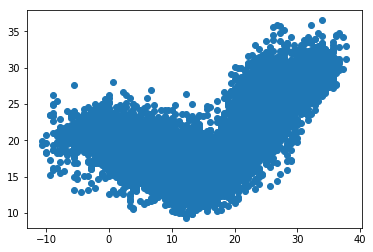

In [518]:
X = b[['air_temperature', 'dew_temperature', 'hour', 'workday']].values
y = b['meter_reading'].values
plt.scatter(X[:,0],y)

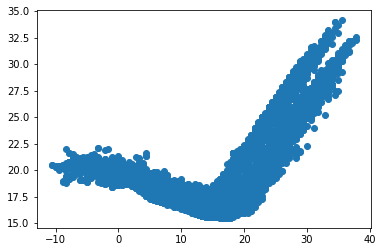

In [519]:
g = nn.predict(X)
plt.scatter(X[:,0],g)
plt.show()

In [520]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [521]:
nn = MLPRegressor(hidden_layer_sizes=(12,), learning_rate_init=0.01, alpha=0.1,
                 learning_rate='adaptive')
nn

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [522]:
nn.fit(X,y)

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [523]:
nn.score(X,y)

0.7179793497891733

# Let's do it for all buildings of type 'Public Services'

In [529]:
b0 = train_df.query('meter==0')
bld_meta = pd.merge(b0, building_meta_df, on='building_id')
bld_meta = bld_meta.drop(columns=['building_id', 'meter'])
print("rows in dataset:", len(bld_meta))
bld_meta.head()

rows in dataset: 12060910


,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


In [537]:
# select only Public services and merge with weather
bps = bld_meta.query('primary_use=="Public services"')
print("Public services records:", len(bps))
bld = pd.merge(bps, weather_train_df, on=['site_id', 'timestamp'])
bld['workhour'] = np.abs(bld['timestamp'].dt.hour - 10.5) < 6.5
bld['workday'] = bld['timestamp'].dt.weekday < 6

bld = bld.drop(columns=['primary_use', 'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure',
                       'wind_direction', 'wind_speed','timestamp'])

bld.head()

Public services records: 1320045


,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,dew_temperature,workhour,workday
0,36.438000,1,118231,NaN,6.0,3.800781,2.400391,False,True
1,12.607100,1,56629,1900.0,6.0,3.800781,2.400391,False,True
2,70.750000,1,118231,NaN,6.0,3.699219,2.400391,False,True
3,25.214300,1,56629,1900.0,6.0,3.699219,2.400391,False,True
4,74.311996,1,118231,NaN,6.0,2.599609,1.900391,False,True


In [542]:
bld = bld.drop(columns=['year_built', 'floor_count'])
b = bld.dropna()
print("rows in dataset:", len(b))

rows in dataset: 1316964


In [557]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/Users/ian/anaconda2/envs/net/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


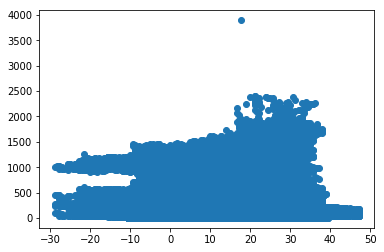

In [558]:
X = b[['air_temperature', 'dew_temperature', 'square_feet', 'workday']].values
y = b['meter_reading'].values
scaler.fit(X,y)
plt.scatter(X[:,0],y)

In [555]:
nn = MLPRegressor(hidden_layer_sizes=(10,), learning_rate_init=0.01, alpha=0.1,
                 learning_rate='adaptive')
nn

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [559]:
X1 = scaler.transform(X)
nn.fit(X1,y)
nn.score(X1,y)

/Users/ian/anaconda2/envs/net/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.6378516124187328

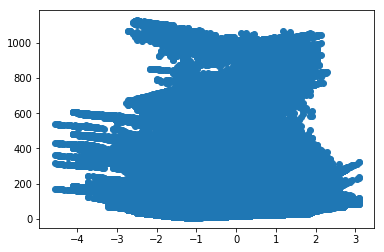

In [566]:
g = nn.predict(X1)
# g = scaler.inverse_transform(g)
plt.scatter(X1[:,0],g)
plt.show()

In [ ]:
test_df = pd.read_csv(root + 'test.csv')
test_df = reduce_mem_usage(test_df)

In [ ]:
test_meters = pd.merge(test_df, building_meta_df, on='building_id')
test_meters.head()

In [ ]:
test_meters = test_meters.sort_values(by=['row_id'])

In [ ]:
coeffs = [(1.96e-3, -2.9), (3.33e-3, 313), (176e-3, -9008), (3.94e-3, 61)]

In [ ]:
te = test_meters.drop( columns=['timestamp','site_id', 'primary_use', 'year_built', 'floor_count'])

In [ ]:
te.head()

In [ ]:
te['building_id'] = 0
for i in range(len(te)):
    if i %1000000 == 0: print(i)
    
    met = te.at[i, 'meter']
    if met == 0:
        te.at[i, 'building_id'] = te.at[i, 'square_feet'] * coeffs[met][0] + coeffs[met][1]
    
    

In [ ]:
te.head()

In [ ]:
te = te.rename(columns={'building_id': 'meter_reading'})
te = te.drop(columns=['meter', 'square_feet'])
te.head()

In [ ]:
te.to_csv("submission4.csv", index=False)

In [ ]:
plt.scatter(X,y)
plt.show()

In [ ]:
one_site = one_use[one_use.site_id == 2]
X = one_site['square_feet'].values
y = one_site['meter_reading'].values

In [ ]:
len(one_site)